# Introduction

This is a demo for an application applying AI for fashion to extract principal color from a clothing of an image. Then predict the trending of this color using the past record from Amazon dataset. There are three modules in this demo:

1/ The clothes segmentation module

2/ The color extraction module

3/ The trend forecasting module dddddd

In [1]:
# Import modules 
import os
import cv2
import time
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io as io
from pathlib import Path
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from typing import Callable, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F

## 0. Data Analysis

In [2]:
ann_train_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_train.json'
ann_val_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_train.json'
ann_test_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_train.json'
path = '/home/vankhoa/datasets/modanet'
coco_path = '/home/vankhoa/datasets/modanet/datasets/coco/'
snapshot_path = '/home/vankhoa/dataset/modanet/results/snapshots/'

In [3]:
# open one annotation coco
with open(ann_train_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

# open one annotation coco
with open(ann_val_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

# open one annotation coco
with open(ann_test_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

dict_keys(['year', 'categories', 'annotations', 'licenses', 'type', 'info', 'images'])
{'file_name': '0736791.jpg', 'width': 400, 'id': 736791, 'license': 3, 'height': 600}
{'segmentation': [[161, 248, 170, 248, 173, 249, 189, 251, 199, 252, 199, 250, 212, 250, 212, 252, 224, 253, 239, 251, 248, 250, 257, 247, 257, 253, 249, 255, 248, 260, 248, 265, 228, 264, 215, 264, 200, 264, 196, 261, 189, 260, 182, 259, 171, 259, 164, 255, 160, 254, 161, 254]], 'area': 1746, 'iscrowd': 0, 'image_id': 736791, 'bbox': [160, 247, 97, 18], 'category_id': 2, 'id': 0}
{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}
41877 219777 13
dict_keys(['year', 'categories', 'annotations', 'licenses', 'type', 'info', 'images'])
{'file_name': '0736791.jpg', 'width': 400, 'id': 736791, 'license': 3, 'height': 600}
{'segmentation': [[161, 248, 170, 248, 173, 249, 189, 251, 199, 252, 199, 250, 212, 250, 212, 252, 224, 253, 239, 251, 248, 250, 257, 247, 257, 253, 249, 255, 248, 260, 248, 265, 228, 264, 215, 264, 20

In [4]:
# count number of images, plot one images

# Initialize the COCO api for instance annotations
coco_train=COCO(ann_train_path)
coco_test=COCO(ann_test_path)

# Load the categories in a variable
catIDs = coco_train.getCatIds()
cats = coco_train.loadCats(catIDs)

print(cats)

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('The class name is', getClassName(7, cats))

loading annotations into memory...
Done (t=1.86s)
creating index...
index created!
loading annotations into memory...
Done (t=2.31s)
creating index...
index created!
[{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}, {'supercategory': 'fashion', 'id': 2, 'name': 'belt'}, {'supercategory': 'fashion', 'id': 3, 'name': 'boots'}, {'supercategory': 'fashion', 'id': 4, 'name': 'footwear'}, {'supercategory': 'fashion', 'id': 5, 'name': 'outer'}, {'supercategory': 'fashion', 'id': 6, 'name': 'dress'}, {'supercategory': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'supercategory': 'fashion', 'id': 8, 'name': 'pants'}, {'supercategory': 'fashion', 'id': 9, 'name': 'top'}, {'supercategory': 'fashion', 'id': 10, 'name': 'shorts'}, {'supercategory': 'fashion', 'id': 11, 'name': 'skirt'}, {'supercategory': 'fashion', 'id': 12, 'name': 'headwear'}, {'supercategory': 'fashion', 'id': 13, 'name': 'scarf/tie'}]
The class name is sunglasses


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Number of images containing all the  classes: 41877
[736791, 997730, 763229]
0406618.jpg
[123950, 123951, 123952, 123953, 123954, 123955, 123956, 123957, 123958, 269327]
[{'segmentation': [[173, 311, 191, 308, 180, 256, 192, 267, 203, 286, 218, 288, 237, 284, 227, 205, 227, 142, 223, 100, 207, 79, 196, 79, 188, 68, 174, 59, 146, 80, 145, 123, 138, 127, 142, 134, 146, 169, 138, 206, 133, 243, 136, 302, 136, 304, 153, 307, 158, 318, 171, 312]], 'area': 26936, 'iscrowd': 0, 'image_id': 406618, 'bbox': [133, 59, 104, 259], 'category_id': 13, 'id': 123950}, {'segmentation': [[191, 47, 210, 38, 234, 38, 246, 36, 242, 11, 233, 5, 209, 0, 189, 2, 174, 21, 173, 42, 171, 57, 177, 57, 191, 48]], 'area': 4275, 'iscrowd': 0, 'image_id': 406618, 'bbox': [171, 0, 75, 57], 'category_id': 12, 'id': 123951}, {'segmentation': [[238, 92, 238, 170, 240, 178, 244, 179, 243, 222, 246, 276, 243, 284, 236, 242, 230, 197, 232, 117, 230, 88, 238, 91], [249, 320, 253, 3

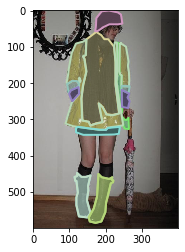

In [5]:
# Fetch class IDs only corresponding to the filterClasses
catIds = coco_train.getCatIds() 
print(catIds)

# Get all images containing the above Category IDs
imgIds = coco_train.getImgIds()
print("Number of images containing all the  classes:", len(imgIds))
print(imgIds[:3])

idx = np.random.randint(0,len(imgIds))


# load and display a random image
img = coco_train.loadImgs(imgIds[idx])[0]
print(img['file_name'])

I = Image.open('{}/images/{}'.format(coco_path,img['file_name']))

plt.imshow(I)

annIds = coco_train.getAnnIds(imgIds=img['id'], iscrowd=None)
print(annIds)

anns = coco_train.loadAnns(annIds)
print(anns)

coco_train.showAnns(anns)

## 1. Dataloader

In [6]:
class ImageData(Dataset):
    def __init__(
        self, 
        annotations: COCO, 
        img_ids: List[int], 
        cat_ids: List[int], 
        root_path: Path, 
        transform: Optional[Callable]=None
    ) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)
        
        img = Image.open(self.files[i])
        mask = Image.fromarray(mask)
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
        
        return img, mask

In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((600,
		400)),
    transforms.ToTensor()
])

dataset_train = ImageData(img_ids=coco_train.getImgIds(), 
                    cat_ids=coco_train.getCatIds(),
                    root_path=Path(coco_path+'/images'), 
                    annotations=coco_train, 
                    transform=transform)

dataset_test = ImageData(img_ids=coco_test.getImgIds(), 
                    cat_ids=coco_train.getCatIds(),
                    root_path=Path(coco_path+'/images'), 
                    annotations=coco_test, 
                    transform=transform)

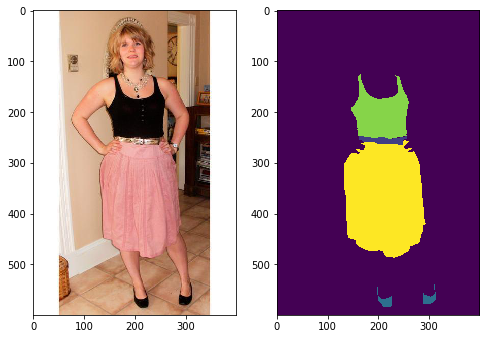

In [8]:
img, label = dataset_train[0]
figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1, 2, 1)
plt.imshow(img.permute(1,2,0).squeeze())
figure.add_subplot(1, 2, 2)
plt.imshow(label.squeeze())
plt.show()

In [9]:
batch_size = 8
num_epochs = 10
device = 'cuda:0'

train_dataloader = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=8)
test_dataloader = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=8)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")

Feature batch shape: torch.Size([2, 3, 600, 400])
Labels batch shape: torch.Size([2, 1, 600, 400])


## 2. Training

In [10]:
# Model
from torchvision import models
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

model = models.segmentation.fcn_resnet101(num_classes=14).to(device)

# initialize loss function and optimizer
lossFunc = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=1e-5)
# calculate steps per epoch for training and test set
trainSteps = len(dataset_train) // batch_size
testSteps = len(dataset_test) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [11]:
# Try one iteration
#logits = model(train_features.to(device))['out']

In [12]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (x, y) in tqdm((train_dataloader)):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x)['out']
        loss = lossFunc(pred, y.long().squeeze(1))
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in tqdm(test_dataloader):
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalTestLoss += lossFunc(pred, y.long())
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

  0%|          | 0/20939 [00:00<?, ?it/s]

[INFO] training the network...



  1%|          | 145/20939 [01:13<2:52:37,  2.01it/s]


  1%|▏         | 288/20939 [02:25<2:52:45,  1.99it/s]


  0%|          | 0/10 [03:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('loss.png')
# serialize the model to disk
torch.save(model, 'model.pth')

## 3. Inference

The clothes segmentation module based on the mask-rcnn model used for instance segmentation. The model is trained on Modanet dataset https://github.com/eBay/modanet, a street fashion images dataset consisting of annotations related to RGB images. ModaNet provides multiple polygon annotations for each image. This dataset is described in a technical paper with the title ModaNet: A Large-Scale Street Fashion Dataset with Polygon Annotations. Each polygon is associated with a label from 13 meta fashion categories. The annotations are based on images in the PaperDoll image set.